In [2]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
events_data = pd.read_csv('event_data_train.csv')

In [127]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [6]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [8]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [9]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [10]:
events_data['day'] = events_data.date.dt.date


In [11]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


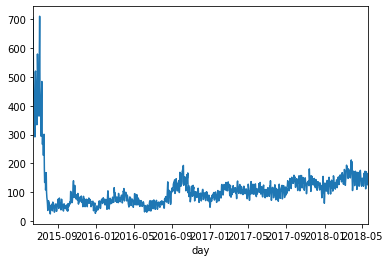

In [12]:
events_data.groupby('day').user_id.nunique().plot();

In [13]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',              
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [14]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [128]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [129]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [17]:
user_scores = submissions_data.pivot_table(index='user_id',
                               columns='submission_status',
                               values='step_id',
                               aggfunc='count',
                               fill_value=0).reset_index()

In [18]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [19]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [20]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [21]:
gap_data = gap_data / (24 * 60 * 60)

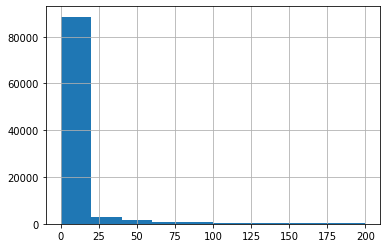

In [22]:
gap_data[gap_data < 200].hist()

In [23]:
gap_data.quantile(0.90)

18.325995370370403

In [24]:
events_data[(events_data.action == 'passed') & (events_data.step_id == events_data.step_id.max())]

,step_id,timestamp,action,user_id,date,day
1780990,158433,1485263664,passed,1046,2017-01-24 13:14:24,2017-01-24
1781275,158433,1485271669,passed,3931,2017-01-24 15:27:49,2017-01-24
1781402,158433,1485276014,passed,14985,2017-01-24 16:40:14,2017-01-24
1782093,158433,1485288441,passed,10626,2017-01-24 20:07:21,2017-01-24
1782261,158433,1485292242,passed,3876,2017-01-24 21:10:42,2017-01-24
...,...,...,...,...,...,...
3478762,158433,1526744472,passed,19147,2018-05-19 15:41:12,2018-05-19
3479191,158433,1526750524,passed,13751,2018-05-19 17:22:04,2018-05-19
3479506,158433,1526754540,passed,19491,2018-05-19 18:29:00,2018-05-19
3479620,158433,1526755659,passed,2058,2018-05-19 18:47:39,2018-05-19


In [25]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})

In [26]:
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [27]:
now = 1526772811
drop_out_treshold = 2592000

In [28]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [29]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [30]:
users_data = users_data.merge(user_scores, on='user_id', how='outer')

In [31]:
users_data = users_data.fillna(0)

In [32]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [33]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',              
                        fill_value=0).reset_index()

In [34]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [35]:
users_data = users_data.merge(users_events_data, how='outer')

In [36]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [37]:
users_data = users_data.merge(users_days, how='outer')

In [38]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [39]:
users_data.user_id.nunique()

19234

In [40]:
events_data.user_id.nunique()

19234

In [41]:
users_data['passed_course'] = users_data.passed > 170

In [42]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [43]:
users_data[users_data.passed_course].day.median()

20.0

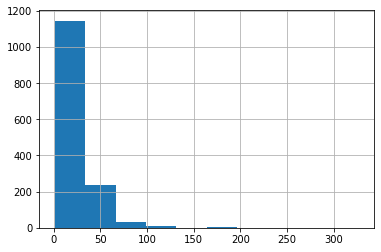

In [44]:
users_data[users_data.passed_course].day.hist()

In [46]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [47]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [48]:
users_data = users_data.merge(user_min_time, how='outer')

In [49]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [50]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [51]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [52]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

In [53]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [54]:
user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [55]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [56]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [57]:
events_data.shape

(3480703, 8)

In [58]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [59]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [60]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [61]:
events_data_train.shape

(1014985, 8)

In [62]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [63]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [64]:
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

In [65]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

In [66]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [67]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [68]:
submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [69]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [70]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [71]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [72]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [73]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [74]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [75]:
X = X.fillna(0)

In [76]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [77]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [78]:
X[(X.is_gone_user == False) & (X.passed_course == False)].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
11,32,1.0,3.0,3.0,0.0,1.000000,14,False,False
20,57,3.0,13.0,13.0,28.0,0.317073,70,False,False
30,78,1.0,2.0,2.0,0.0,1.000000,13,False,False
53,156,1.0,2.0,2.0,0.0,1.000000,10,False,False


In [79]:
X[~((X.is_gone_user == False) & (X.passed_course == False))].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [80]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [81]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [82]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [83]:
y = X.passed_course.map(int)

In [84]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [85]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [86]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [134]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [130]:
submissions_data = submissions_data.drop(columns=['date', 'day'])
submissions_data = pd.get_dummies(submissions_data, columns=['submission_status'])

last_time = submissions_data.groupby('user_id').agg({ 'timestamp': 'max' })
last_time = last_time.rename(columns={ 'timestamp': 'last_timestamp' })

last_step_id = submissions_data.groupby('user_id').agg({ 'step_id': 'max' })
last_step_id = last_step_id.rename(columns={ 'step_id': 'last_step_id' })

submissions_data = submissions_data.merge(last_time, on='user_id')
submissions_data = submissions_data.merge(last_step_id, on='user_id')

In [131]:
submissions_data.head()

,step_id,timestamp,user_id,submission_status_correct,submission_status_wrong,last_timestamp,last_step_id
0,31971,1434349275,15853,1,0,1479734163,120745
1,31972,1434348300,15853,1,0,1479734163,120745
2,31972,1478852149,15853,0,1,1479734163,120745
3,31972,1478852164,15853,1,0,1479734163,120745
4,31976,1434348123,15853,0,1,1479734163,120745


In [133]:
filtered = submissions_data[
    (submissions_data.timestamp == submissions_data.last_timestamp) & \
    (submissions_data.submission_status_correct == 0)
]

filtered.groupby('step_id').agg({
    'user_id': 'count'
}).sort_values('user_id', ascending=False).head(10)

,user_id
step_id,
31978,154
32812,133
32031,97
32202,92
33481,78
31977,60
32173,47
31972,45
31971,43


In [135]:
submissions_data.sort_values(['user_id', 'timestamp'], ascending=False).drop_duplicates(['user_id'])\
        .query("submission_status == 'wrong'").groupby('step_id')\
        .count().sort_values('submission_status').tail(1)

,timestamp,submission_status,user_id,date,day
step_id,,,,,
31978,154,154,154,154,154


In [136]:
submissions_data = pd.read_csv('submissions_data_train.csv')

submissions_data_by_step = submissions_data \
    .pivot_table(values='timestamp', index=['user_id', 'step_id'], aggfunc = 'max', 
                 columns='submission_status', fill_value=0) \
    .reset_index()

submissions_data_by_step['is_solved'] = submissions_data_by_step.correct > 0

users_max_time = submissions_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})


not_solved_steps = submissions_data_by_step[submissions_data_by_step.is_solved == False]

not_solved_steps = not_solved_steps.merge(users_max_time, on='user_id')

not_solved_steps['is_last_action'] = not_solved_steps.wrong == not_solved_steps.last_timestamp

not_solved_steps_last_action = not_solved_steps[not_solved_steps.is_last_action == True]

not_solved_steps_last_action.groupby('step_id', as_index=False) \
    .agg({'user_id': 'count'}).sort_values('user_id', ascending=False).head()


,step_id,user_id
4,31978,151
28,32812,130
11,32031,95
19,32202,88
42,33481,78
